In [1]:
# coding: utf-8
%matplotlib inline


import os as os
from IPython import embed

from datetime import datetime
import glob
import math as math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from scipy.stats import gmean
import statsmodels.api as sm
import subprocess
import unicodedata

# import statsmodels.formula.api as smf  # <- NB fails with some index names (Pygments issue)



sns.set(style='whitegrid')

def get_filenames(import_path, wildcard='*.csv', filt=()):
    names = glob.glob(os.path.join(import_path, wildcard))
    if filt:
        names = [name for name in names if any(f in name for f in filt)]
    
    return names

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
files = get_filenames('../raw_data/',)
files

['../raw_data/20170223_000000_agent_statistics.csv',
 '../raw_data/20170223_000000_group_statistics.csv',
 '../raw_data/20170224_000000_agent_statistics.csv',
 '../raw_data/20170224_000000_group_statistics.csv',
 '../raw_data/20170227_000000_agent_statistics.csv',
 '../raw_data/20170227_000000_group_statistics.csv',
 '../raw_data/20170228_000000_agent_statistics.csv',
 '../raw_data/20170228_000000_group_statistics.csv',
 '../raw_data/20170301_000000_agent_statistics.csv',
 '../raw_data/20170301_000000_group_statistics.csv',
 '../raw_data/20170303_000000_agent_statistics.csv',
 '../raw_data/20170303_000000_group_statistics.csv',
 '../raw_data/20170306_000000_agent_statistics.csv',
 '../raw_data/20170306_000000_group_statistics.csv',
 '../raw_data/20170307_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_agent_statistics.csv',
 '../raw_data/20170308_000000_group_statistics.csv',
 '../raw_data/20170309_000000_agent_statistics.csv',
 '../raw_data/20170309_000000_group_statistics

In [3]:
agent_files = get_filenames('../raw_data/', filt=('agent',))
group_files = get_filenames('../raw_data/', filt=('group',))

In [117]:
def read_data(path):
    df = pd.read_csv(path)
    
    # remove whitespace and '.' from column names to allow easier referencing later
    df.rename(columns=lambda x: x.strip().replace('.', ''), inplace=True)  
    
    # store filename in 'filename' column in case needed later
    try:
        df['filename'] = path.split('/')[-1:][0]
    except:
        df['filename'] = path
    return df


def add_indexes(df):
    if not 'timestamp' in df.columns:
        filename_date = df['filename'].map(lambda x: x.split('_')[0])
        df['date'] = pd.to_datetime(filename_date)
        df.set_index(['date'], inplace=True, drop=True, append=False)
    else:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        ts = df['timestamp']
        df['date'] = ts.map(lambda x: x.date())
        df['time'] = ts.map(lambda x: x.time())
        df.set_index(['date', 'time'], inplace=True, drop=True, append=False)
    if 'agent name' in df.columns:
        df.set_index(['agent name'], inplace=True, drop=True, append=True)
    return df


def parse_time_to_timedelta(df):
    for col in df.columns:
        if re.search(r'time$', col, re.I):
            try:
                df[col] = df[col].map(lambda x: pd.to_timedelta(x))
            except:
                raise TypeError('cannot parse "{}" to time'.format(col))
    
    return df


def concat_data(filepaths):
    frames = []
    
    for filepath in filepaths:
        df = read_data(filepath)
        df = df.dropna()
        df = add_indexes(df)
        df = parse_time_to_timedelta(df)
        frames.append(df)  # append dataframe to list
        
    data = pd.concat(frames)  # concatenate dataframes in frames
    data.columns.name = 'param'
    
    return data

agent_data = concat_data(agent_files)
print(agent_data.shape)
agent_data.head(10)

(272, 6)


param                      num calls handled  num calls unanswered  \
date       agent name                                                
2017-02-23 Reception L1                   49                    50   
           Back Office3                   64                    62   
           Reception Desk                 52                    45   
           Back Office1                    4                     3   
2017-02-24 Reception L1                   78                    57   
           Back Office3                   63                    46   
           Reception Desk                 65                    35   
           Back Office1                   15                     1   
2017-02-27 Reception L1                   69                    26   
           Back Office3                   99                    91   

param                     avg call time total talk time total staffed time  \
date       agent name                                                        
2017-02-23 Reception L1        00:02:11        01:30:45             1 days   
           Back Office3        00:01:43        01:32:51             1 days   
           Reception Desk      00:01:53        01:25:32             1 days   
           Back Office1        00:06:13        00:22:45             1 days   
2017-02-24 Reception L1        00:02:21        01:58:45             1 days   
           Back Office3        00:02:03        01:34:30             1 days   
           Reception Desk      00:02:27        01:52:06             1 days   
           Back Office1        00:04:32        00:58:19             1 days   
2017-02-27 Reception L1        00:04:41        03:05:19             1 days   
           Back Office3        00:02:13        03:08:12             1 days   

param                                                  filename  
date       agent name                                            
2017-02-23 Reception L1    20170223_000000_agent_statistics.csv  
           Back Office3    20170223_000000_agent_statistics.csv  
           Reception Desk  20170223_000000_agent_statistics.csv  
           Back Office1    20170223_000000_agent_statistics.csv  
2017-02-24 Reception L1    20170224_000000_agent_statistics.csv  
           Back Office3    20170224_000000_agent_statistics.csv  
           Reception Desk  20170224_000000_agent_statistics.csv  
           Back Office1    20170224_000000_agent_statistics.csv  
2017-02-27 Reception L1    20170227_000000_agent_statistics.csv  
           Back Office3    20170227_000000_agent_statistics.csv

In [118]:
agent_data['avg call time'].head()

date        agent name    
2017-02-23  Reception L1     00:02:11
            Back Office3     00:01:43
            Reception Desk   00:01:53
            Back Office1     00:06:13
2017-02-24  Reception L1     00:02:21
Name: avg call time, dtype: timedelta64[ns]

In [119]:
agent_data.index.get_level_values(0)

DatetimeIndex(['2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-24', '2017-02-24', '2017-02-24', '2017-02-24',
               '2017-02-27', '2017-02-27',
               ...
               '2017-06-05', '2017-06-05', '2017-06-06', '2017-06-06',
               '2017-06-06', '2017-06-06', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08'],
              dtype='datetime64[ns]', name='date', length=272, freq=None)

In [120]:
agent_data_clean = agent_data.dropna()
agent_data_clean = agent_data_clean.drop('filename', axis=1)
agent_data_clean = agent_data_clean.T
agent_data_clean.head(10)

date                       2017-02-23                                    \
agent name               Reception L1     Back Office3   Reception Desk   
param                                                                     
num calls handled                  49               64               52   
num calls unanswered               50               62               45   
avg call time         0 days 00:02:11  0 days 00:01:43  0 days 00:01:53   
total talk time       0 days 01:30:45  0 days 01:32:51  0 days 01:25:32   
total staffed time    1 days 00:00:00  1 days 00:00:00  1 days 00:00:00   

date                                        2017-02-24                   \
agent name               Back Office1     Reception L1     Back Office3   
param                                                                     
num calls handled                   4               78               63   
num calls unanswered                3               57               46   
avg call time         0 days 00:06:13  0 days 00:02:21  0 days 00:02:03   
total talk time       0 days 00:22:45  0 days 01:58:45  0 days 01:34:30   
total staffed time    1 days 00:00:00  1 days 00:00:00  1 days 00:00:00   

date                                                         2017-02-27  \
agent name             Reception Desk     Back Office1     Reception L1   
param                                                                     
num calls handled                  65               15               69   
num calls unanswered               35                1               26   
avg call time         0 days 00:02:27  0 days 00:04:32  0 days 00:04:41   
total talk time       0 days 01:52:06  0 days 00:58:19  0 days 03:05:19   
total staffed time    1 days 00:00:00  1 days 00:00:00  1 days 00:00:00   

date                                        ...              2017-06-05  \
agent name               Back Office3       ...          Reception Desk   
param                                       ...                           
num calls handled                  99       ...                      64   
num calls unanswered               91       ...                      21   
avg call time         0 days 00:02:13       ...         0 days 00:03:18   
total talk time       0 days 03:08:12       ...         0 days 02:30:42   
total staffed time    1 days 00:00:00       ...         1 days 00:00:00   

date                                        2017-06-06                   \
agent name               Back Office1     Reception L1     Back Office3   
param                                                                     
num calls handled                  25               27               56   
num calls unanswered                6               11               29   
avg call time         0 days 00:01:53  0 days 00:04:15  0 days 00:01:25   
total talk time       0 days 00:35:46  0 days 01:22:53  0 days 01:08:52   
total staffed time    1 days 00:00:00  1 days 00:00:00  1 days 00:00:00   

date                                                         2017-06-08  \
agent name             Reception Desk     Back Office1     Reception L1   
param                                                                     
num calls handled                  20                7               75   
num calls unanswered                6                1               50   
avg call time         0 days 00:03:17  0 days 00:01:20  0 days 00:02:11   
total talk time       0 days 00:44:20  0 days 00:08:19  0 days 02:09:08   
total staffed time    1 days 00:00:00  1 days 00:00:00  1 days 00:00:00   

date                                                                     
agent name               Back Office3   Reception Desk     Back Office1  
param                                                                    
num calls handled                  74               47               10  
num calls unanswered               75               46               14  
avg call time         0 

In [121]:
agent_data_by_date = agent_data_clean.stack('date')
agent_data_by_date.head(10)

agent name                   Back Office1 Back Office3 Reception Desk  \
param             date                                                  
num calls handled 2017-02-23            4           64             52   
                  2017-02-24           15           63             65   
                  2017-02-27            0           99             85   
                  2017-02-28            0           47             25   
                  2017-03-01           60           58             49   
                  2017-03-03           15           66             48   
                  2017-03-06           66           63             79   
                  2017-03-07            6           60             75   
                  2017-03-08           25           73             27   
                  2017-03-09           11           42             38   

agent name                   Reception L1  
param             date                     
num calls handled 2017-02-23           49  
                  2017-02-24           78  
                  2017-02-27           69  
                  2017-02-28           28  
                  2017-03-01           97  
                  2017-03-03           72  
                  2017-03-06           86  
                  2017-03-07           71  
                  2017-03-08           72  
                  2017-03-09           63

In [122]:
agent_data_by_date['Total'] = agent_data_by_date.sum(axis=1)
agent_data_by_date.head(10)

agent name                   Back Office1 Back Office3 Reception Desk  \
param             date                                                  
num calls handled 2017-02-23            4           64             52   
                  2017-02-24           15           63             65   
                  2017-02-27            0           99             85   
                  2017-02-28            0           47             25   
                  2017-03-01           60           58             49   
                  2017-03-03           15           66             48   
                  2017-03-06           66           63             79   
                  2017-03-07            6           60             75   
                  2017-03-08           25           73             27   
                  2017-03-09           11           42             38   

agent name                   Reception L1 Total  
param             date                           
num calls handled 2017-02-23           49   169  
                  2017-02-24           78   221  
                  2017-02-27           69   253  
                  2017-02-28           28   100  
                  2017-03-01           97   264  
                  2017-03-03           72   201  
                  2017-03-06           86   294  
                  2017-03-07           71   212  
                  2017-03-08           72   197  
                  2017-03-09           63   154

In [123]:
agent_data_by_date.tail(10)

agent name                        Back Office1     Back Office3  \
param              date                                           
total staffed time 2017-05-23  1 days 00:00:00  1 days 00:00:00   
                   2017-05-24  1 days 00:00:00  1 days 00:00:00   
                   2017-05-25  1 days 00:00:00  1 days 00:00:00   
                   2017-05-26  1 days 00:00:00  1 days 00:00:00   
                   2017-05-30  1 days 00:00:00  1 days 00:00:00   
                   2017-05-31  1 days 00:00:00  1 days 00:00:00   
                   2017-06-01  1 days 00:00:00  1 days 00:00:00   
                   2017-06-05  1 days 00:00:00  1 days 00:00:00   
                   2017-06-06  1 days 00:00:00  1 days 00:00:00   
                   2017-06-08  1 days 00:00:00  1 days 00:00:00   

agent name                      Reception Desk     Reception L1  \
param              date                                           
total staffed time 2017-05-23  1 days 00:00:00  1 days 00:00:00   
                   2017-05-24  1 days 00:00:00  1 days 00:00:00   
                   2017-05-25  1 days 00:00:00  1 days 00:00:00   
                   2017-05-26  1 days 00:00:00  1 days 00:00:00   
                   2017-05-30  1 days 00:00:00  1 days 00:00:00   
                   2017-05-31  1 days 00:00:00  1 days 00:00:00   
                   2017-06-01  1 days 00:00:00  1 days 00:00:00   
                   2017-06-05  1 days 00:00:00  1 days 00:00:00   
                   2017-06-06  1 days 00:00:00  1 days 00:00:00   
                   2017-06-08  1 days 00:00:00  1 days 00:00:00   

agent name                               Total  
param              date                         
total staffed time 2017-05-23  4 days 00:00:00  
                   2017-05-24  4 days 00:00:00  
                   2017-05-25  4 days 00:00:00  
                   2017-05-26  4 days 00:00:00  
                   2017-05-30  4 days 00:00:00  
                   2017-05-31  4 days 00:00:00  
                   2017-06-01  4 days 00:00:00  
                   2017-06-05  4 days 00:00:00  
                   2017-06-06  4 days 00:00:00  
                   2017-06-08  4 days 00:00:00

In [124]:
agent_data_by_date.stack('agent name').unstack(['param', 'agent name'])

param      num calls handled                                                 \
agent name      Back Office1 Back Office3 Reception Desk Reception L1 Total   
date                                                                          
2017-02-23                 4           64             52           49   169   
2017-02-24                15           63             65           78   221   
2017-02-27                 0           99             85           69   253   
2017-02-28                 0           47             25           28   100   
2017-03-01                60           58             49           97   264   
2017-03-03                15           66             48           72   201   
2017-03-06                66           63             79           86   294   
2017-03-07                 6           60             75           71   212   
2017-03-08                25           73             27           72   197   
2017-03-09                11           42             38           63   154   
2017-03-10                 8           32             47           61   148   
2017-03-14                 3           90             40           54   187   
2017-03-15                37           39             37           65   178   
2017-03-16                 2           39             32           50   123   
2017-03-20                56           72             73           71   272   
2017-03-21                15           61             45           56   177   
2017-03-22                 0           68             47           56   171   
2017-03-23                15           45             59           77   196   
2017-03-24                 7           71             49           85   212   
2017-03-27                34           56             67           68   225   
2017-03-28                 2           67             54           58   181   
2017-03-29                23           50             53           67   193   
2017-03-30                 5           41             43           67   156   
2017-03-31                12           47             38           67   164   
2017-04-03                52           31             61           75   219   
2017-04-05                 8           31             14           19    72   
2017-04-06                 0           51             57           74   182   
2017-04-07                25           36             46           79   186   
2017-04-08                 0            0              0            0     0   
2017-04-11                23           46             45           67   181   
...                      ...          ...            ...          ...   ...   
2017-04-21                 0           28             52           73   153   
2017-04-22                 0            0              0            0     0   
2017-04-23                 0            0              0            0     0   
2017-04-24                26           68             86          100   280   
2017-04-25                20           44             18           30   112   
2017-04-26                 4           60             55           75   194   
2017-04-27                17           47             43           58   165   
2017-05-01                 0            0              0            0     0   
2017-05-02                27           75            100           97   299   
2017-05-03                27           65             69           54   215   
2017-05-05                 5           43             64           74   186   
2017-05-09                26           68             58           59   211   
2017-05-10                 8           53             26           28   115   
2017-05-11                16           58             59           92   225   
2017-05-12                10           54             44           82   190   
2017-05-15                26           54             71           90   241   
2017-05-16                 2           82         

In [125]:
group_data = concat_data(group_files)
print(group_data.shape)
group_data.head(10)

(6528, 11)


param                         timestamp  num busy overflows  \
date       time                                               
2017-02-23 00:00:00 2017-02-23 00:00:00                   0   
           00:15:00 2017-02-23 00:15:00                   0   
           00:30:00 2017-02-23 00:30:00                   0   
           00:45:00 2017-02-23 00:45:00                   0   
           01:00:00 2017-02-23 01:00:00                   0   
           01:15:00 2017-02-23 01:15:00                   0   
           01:30:00 2017-02-23 01:30:00                   0   
           01:45:00 2017-02-23 01:45:00                   0   
           02:00:00 2017-02-23 02:00:00                   0   
           02:15:00 2017-02-23 02:15:00                   0   

param                num calls answered  num calls abandoned  \
date       time                                                
2017-02-23 00:00:00                   0                    0   
           00:15:00                   0                    0   
           00:30:00                   0                    0   
           00:45:00                   0                    0   
           01:00:00                   0                    0   
           01:15:00                   0                    0   
           01:30:00                   0                    0   
           01:45:00                   0                    0   
           02:00:00                   0                    0   
           02:15:00                   0                    0   

param                num calls transferred  num calls timed out  \
date       time                                                   
2017-02-23 00:00:00                      0                    0   
           00:15:00                      0                    0   
           00:30:00                      0                    0   
           00:45:00                      0                    0   
           01:00:00                      0                    0   
           01:15:00                      0                    0   
           01:30:00                      0                    0   
           01:45:00                      0                    0   
           02:00:00                      0                    0   
           02:15:00                      0                    0   

param                avg num agents talking  avg num agents staffed  \
date       time                                                       
2017-02-23 00:00:00                     0.0                     4.0   
           00:15:00                     0.0                     4.0   
           00:30:00                     0.0                     4.0   
           00:45:00                     0.0                     4.0   
           01:00:00                     0.0                     4.0   
           01:15:00                     0.0                     4.0   
           01:30:00                     0.0                     4.0   
           01:45:00                     0.0                     4.0   
           02:00:00                     0.0                     4.0   
           02:15:00                     0.0                     4.0   

param               avg wait time avg abandonment time  \
date       time                                          
2017-02-23 00:00:00        0 days               0 days   
           00:15:00        0 days               0 days   
           00:30:00        0 days               0 days   
           00:45:00        0 days               0 days   
           01:00:00        0 days               0 days   
           01:15:00        0 days               0 days   
           01:30:00        0 days               0 days   
           01:45:00        0 days               0 days   
           02:00:00        0 days               0 days   
           02:15:00        0 days               0 days   

param                                            filename  
date       time                                            

In [126]:
group_data.index.get_level_values('time')

Index([00:00:00, 00:15:00, 00:30:00, 00:45:00, 01:00:00, 01:15:00, 01:30:00,
       01:45:00, 02:00:00, 02:15:00,
       ...
       21:30:00, 21:45:00, 22:00:00, 22:15:00, 22:30:00, 22:45:00, 23:00:00,
       23:15:00, 23:30:00, 23:45:00],
      dtype='object', name='time', length=6528)

In [127]:
group_data.index

MultiIndex(levels=[[2017-02-23 00:00:00, 2017-02-24 00:00:00, 2017-02-27 00:00:00, 2017-02-28 00:00:00, 2017-03-01 00:00:00, 2017-03-03 00:00:00, 2017-03-06 00:00:00, 2017-03-08 00:00:00, 2017-03-09 00:00:00, 2017-03-10 00:00:00, 2017-03-13 00:00:00, 2017-03-14 00:00:00, 2017-03-15 00:00:00, 2017-03-16 00:00:00, 2017-03-17 00:00:00, 2017-03-20 00:00:00, 2017-03-21 00:00:00, 2017-03-22 00:00:00, 2017-03-23 00:00:00, 2017-03-24 00:00:00, 2017-03-27 00:00:00, 2017-03-28 00:00:00, 2017-03-30 00:00:00, 2017-03-31 00:00:00, 2017-04-03 00:00:00, 2017-04-04 00:00:00, 2017-04-05 00:00:00, 2017-04-07 00:00:00, 2017-04-08 00:00:00, 2017-04-11 00:00:00, 2017-04-12 00:00:00, 2017-04-13 00:00:00, 2017-04-14 00:00:00, 2017-04-16 00:00:00, 2017-04-17 00:00:00, 2017-04-18 00:00:00, 2017-04-19 00:00:00, 2017-04-20 00:00:00, 2017-04-21 00:00:00, 2017-04-22 00:00:00, 2017-04-23 00:00:00, 2017-04-24 00:00:00, 2017-04-25 00:00:00, 2017-04-26 00:00:00, 2017-04-27 00:00:00, 2017-05-01 00:00:00, 2017-05-02 00:

In [128]:
group_data

param                         timestamp  num busy overflows  \
date       time                                               
2017-02-23 00:00:00 2017-02-23 00:00:00                   0   
           00:15:00 2017-02-23 00:15:00                   0   
           00:30:00 2017-02-23 00:30:00                   0   
           00:45:00 2017-02-23 00:45:00                   0   
           01:00:00 2017-02-23 01:00:00                   0   
           01:15:00 2017-02-23 01:15:00                   0   
           01:30:00 2017-02-23 01:30:00                   0   
           01:45:00 2017-02-23 01:45:00                   0   
           02:00:00 2017-02-23 02:00:00                   0   
           02:15:00 2017-02-23 02:15:00                   0   
           02:30:00 2017-02-23 02:30:00                   0   
           02:45:00 2017-02-23 02:45:00                   0   
           03:00:00 2017-02-23 03:00:00                   0   
           03:15:00 2017-02-23 03:15:00                   0   
           03:30:00 2017-02-23 03:30:00                   0   
           03:45:00 2017-02-23 03:45:00                   0   
           04:00:00 2017-02-23 04:00:00                   0   
           04:15:00 2017-02-23 04:15:00                   0   
           04:30:00 2017-02-23 04:30:00                   0   
           04:45:00 2017-02-23 04:45:00                   0   
           05:00:00 2017-02-23 05:00:00                   0   
           05:15:00 2017-02-23 05:15:00                   0   
           05:30:00 2017-02-23 05:30:00                   0   
           05:45:00 2017-02-23 05:45:00                   0   
           06:00:00 2017-02-23 06:00:00                   0   
           06:15:00 2017-02-23 06:15:00                   0   
           06:30:00 2017-02-23 06:30:00                   0   
           06:45:00 2017-02-23 06:45:00                   0   
           07:00:00 2017-02-23 07:00:00                   0   
           07:15:00 2017-02-23 07:15:00                   0   
...                                 ...                 ...   
2017-06-08 16:30:00 2017-06-08 16:30:00                   0   
           16:45:00 2017-06-08 16:45:00                   0   
           17:00:00 2017-06-08 17:00:00                   0   
           17:15:00 2017-06-08 17:15:00                   0   
           17:30:00 2017-06-08 17:30:00                   0   
           17:45:00 2017-06-08 17:45:00                   0   
           18:00:00 2017-06-08 18:00:00                   0   
           18:15:00 2017-06-08 18:15:00                   0   
           18:30:00 2017-06-08 18:30:00                   0   
           18:45:00 2017-06-08 18:45:00                   0   
           19:00:00 2017-06-08 19:00:00                   0   
           19:15:00 2017-06-08 19:15:00                   0   
           19:30:00 2017-06-08 19:30:00                   0   
           19:45:00 2017-06-08 19:45:00                   0   
           20:00:00 2017-06-08 20:00:00                   0   
           20:15:00 2017-06-08 20:15:00                   0   
           20:30:00 2017-06-08 20:30:00                   0   
           20:45:00 2017-06-08 20:45:00                   0   
           21:00:00 2017-06-08 21:00:00                   0   
           21:15:00 2017-06-08 21:15:00                   0   
           21:30:00 2017-06-08 21:30:00                   0   
           21:45:00 2017-06-08 21:45:00                   0   
           22:00:00 2017-06-08 22:00:00                   0   
           22:15:00 2017-06-08 22:15:00                   0   
           22:30:00 2017-06-08 22:30:00                   0   
           22:45:00 2017-06-08 22:45:00                   0   
           23:00:00 2017-06-08 23:00:00                   0   
           23:15:00 2017-06-08 23:15:00                   0   
           23:30:00 2017-06-08 23:30:00                   0   
           23:45:00 2017-06-08 23:45:00                   0   

param                num calls

In [129]:
group_data.index.get_level_values('date')

DatetimeIndex(['2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23', '2017-02-23', '2017-02-23',
               '2017-02-23', '2017-02-23',
               ...
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08', '2017-06-08', '2017-06-08',
               '2017-06-08', '2017-06-08'],
              dtype='datetime64[ns]', name='date', length=6528, freq=None)

In [130]:
group_data.unstack('date')['num calls answered'].columns

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

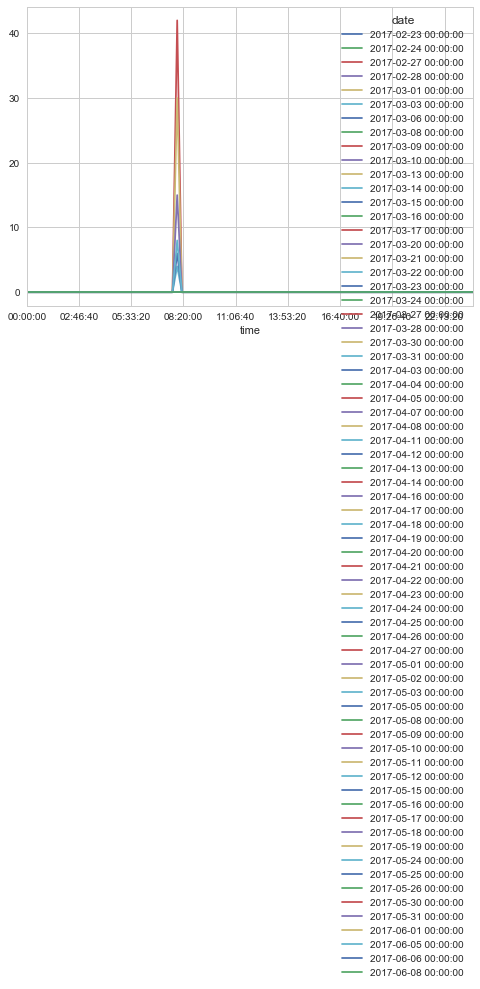

In [132]:
group_data.unstack('date')['num busy overflows'].plot()

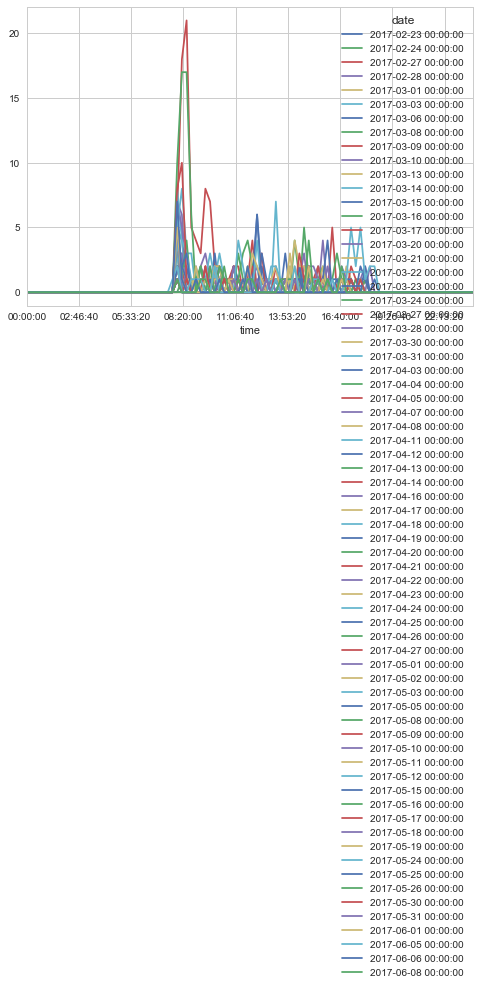

In [133]:
group_data.unstack('date')['num calls abandoned'].plot()

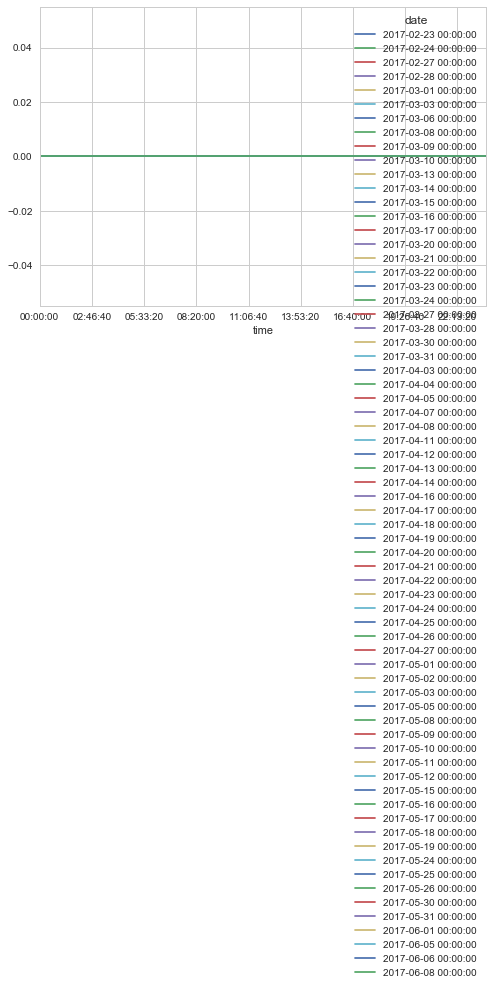

In [134]:
group_data.unstack('date')['num calls transferred'].plot()

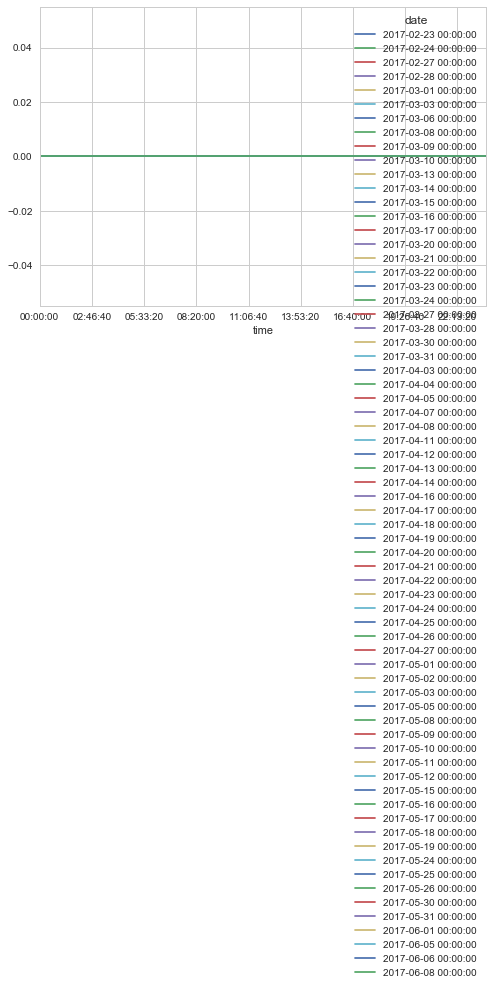

In [135]:
group_data.unstack('date')['num calls timed out'].plot()

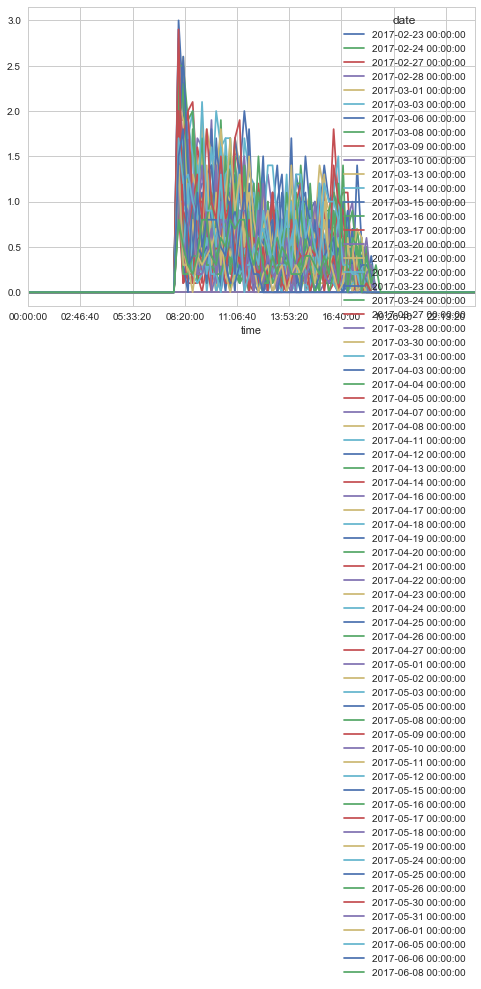

In [136]:
group_data.unstack('date')['avg num agents talking'].plot()

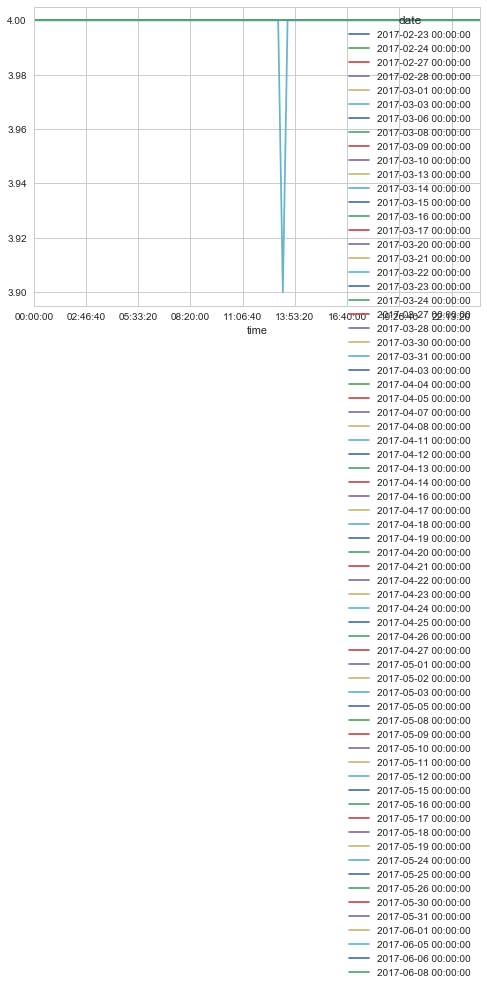

In [137]:
group_data.unstack('date')['avg num agents staffed'].plot()

In [165]:
q = group_data.unstack('date')['avg wait time']
# q.rename(columns=lambda x: x.date(), inplace=True)
q.columns

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

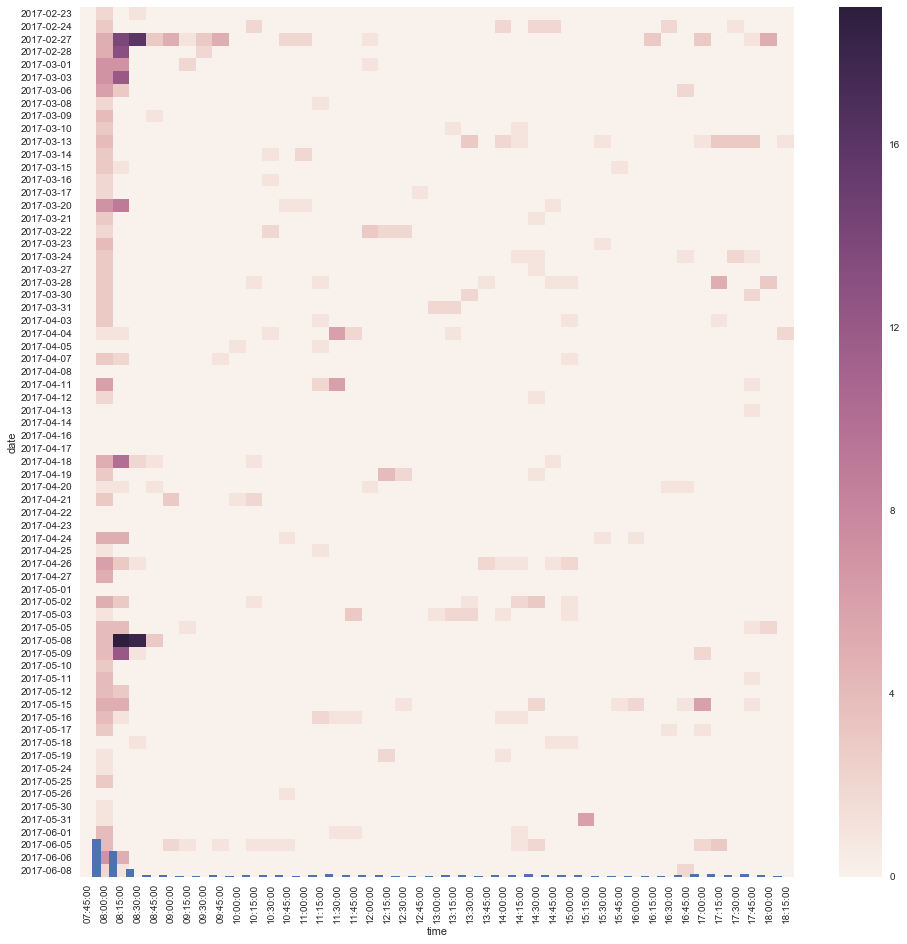

In [170]:
q = group_data.unstack('date')['avg wait time'].astype('timedelta64[m]')
q.rename(columns=lambda x: x.date(), inplace=True)
mask = np.logical_and(query.index >= datetime(1900,1,1,7,45,0).time(), query.index <= datetime(1900,1,1,18,15,0).time())
q = q.loc[mask]
fig, ax = plt.subplots(figsize=(16,16))
q.mean(axis=1).plot(kind='bar', ax=ax, )
sns.heatmap(q.T, ax=ax)

0.0


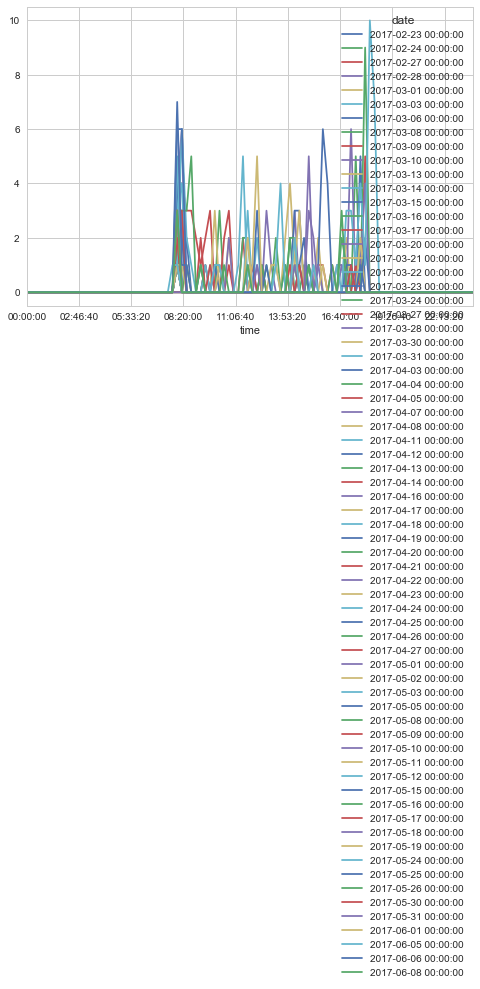

In [509]:
avg_abandonment_time = group_split_datetime['avg abandonment time'].astype('timedelta64[m]')
print(avg_abandonment_time.quantile(q=0.95))
avg_abandonment_time.unstack('date').plot()

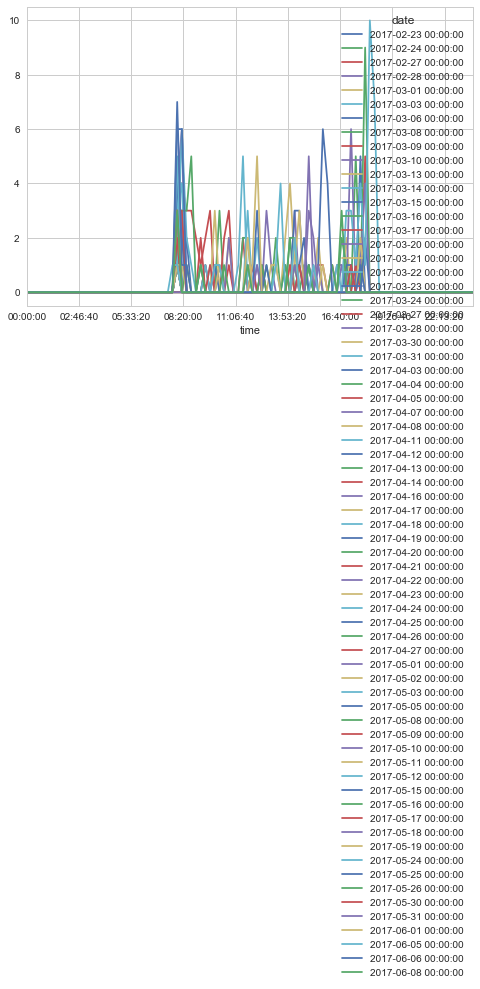

In [748]:
q = avg_abandonment_time.unstack('date')
q.plot()

In [158]:
# ind = q.index.get_level_values(0)
# dow = [x.weekday() for x in ind]
# ind
group_data['num calls answered'].unstack('date').T.index

DatetimeIndex(['2017-02-23', '2017-02-24', '2017-02-27', '2017-02-28',
               '2017-03-01', '2017-03-03', '2017-03-06', '2017-03-08',
               '2017-03-09', '2017-03-10', '2017-03-13', '2017-03-14',
               '2017-03-15', '2017-03-16', '2017-03-17', '2017-03-20',
               '2017-03-21', '2017-03-22', '2017-03-23', '2017-03-24',
               '2017-03-27', '2017-03-28', '2017-03-30', '2017-03-31',
               '2017-04-03', '2017-04-04', '2017-04-05', '2017-04-07',
               '2017-04-08', '2017-04-11', '2017-04-12', '2017-04-13',
               '2017-04-14', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24', '2017-04-25', '2017-04-26',
               '2017-04-27', '2017-05-01', '2017-05-02', '2017-05-03',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12', '2017-05-15', '2017-05-16',
      

/Users/duncan/anaconda/envs/single-cell-bioinformatics/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


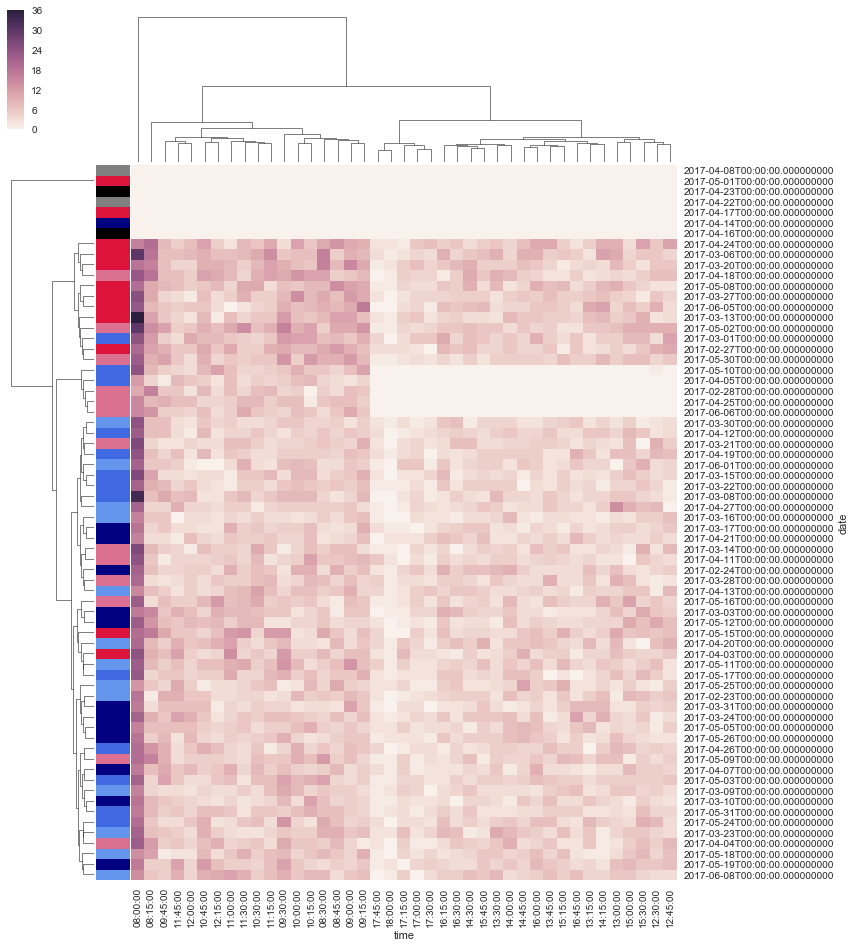

In [186]:
query = group_data['num calls answered'].unstack('date')
day_of_week = [x.weekday() for x in group_data['num calls answered'].unstack('date').T.index]
mask = np.logical_and(query.index >= datetime(1900,1,1,8,0,0).time(), query.index < datetime(1900,1,1,18,15,0).time())
query = pd.DataFrame(query, index=query.index)

# fig, ax = plt.subplots(figsize=(12,16))
day_to_color = {0:'Crimson', 1:'PaleVioletRed', 2:'RoyalBlue', 3:'CornflowerBlue', 4:'Navy', 5:'Grey', 6:'Black'}
day_colors = [day_to_color[day] for day in day_of_week]
g = sns.clustermap(query[mask].T, col_cluster=True, figsize=(12,16), method='ward', row_colors=day_colors)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0,);


In [ ]:
# fig, ax = plt.subplots(figsize=(16,8))
# unstacked = q.unstack('date')
# unstacked.mean(axis=1).unstack('day').plot(kind='bar', ax=ax)
# # gp = q.groupby(q.day)

In [660]:
for x in gp:
    print (x)

(0, param                avg abandonment time  day
date       time                               
2017-02-27 00:00:00                   0.0    0
           00:15:00                   0.0    0
           00:30:00                   0.0    0
           00:45:00                   0.0    0
           01:00:00                   0.0    0
           01:15:00                   0.0    0
           01:30:00                   0.0    0
           01:45:00                   0.0    0
           02:00:00                   0.0    0
           02:15:00                   0.0    0
           02:30:00                   0.0    0
           02:45:00                   0.0    0
           03:00:00                   0.0    0
           03:15:00                   0.0    0
           03:30:00                   0.0    0
           03:45:00                   0.0    0
           04:00:00                   0.0    0
           04:15:00                   0.0    0
           04:30:00                   0.0    0
         